In [ ]:
"""
Author: Joe Zavorskas
Date Started: 6/26/2023
Last Edit: 04/11/2024

Main file for diatom succession simulations. Simulates the annual succession pattern between
Thalassiosira species and Chaetoceros species in the Arctic. Symbiosis between Chaetoceros and 
a cyanobacterium is included, which relieves nitrogen stress on Chaetoceros after nitrate has been depleted.

A detailed input instance is passed throughout the differential equation function defined below, which 
contains information required to calculate light intensity, and saved LP solutions for the diatom-only FBA
and the symbiotic FBA problems.

"""

In [1]:
# Import necessary packages:
import cobra
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
import netCDF4
from IPython.display import clear_output

# Author-written functions:
import DaySolve, NightSolve, fluxCalc, Light, Extras
import MergeDaySolve, MergeNightSolve, MergefluxCalc, MergeLoadModel

In [2]:
# Initialize a dictionary to hold all inputs to the class.
Inputs = {}

# User defined inputs here!!! Names will be more descriptive in this user-facing section.
Inputs['Year'] = 2024
Inputs['DayNumber'] = 0 # Daynumber 0 is a flag for not using DAYNUM/YY mode.
Inputs['Month'] = 3 # Month 0 is a flag for not using MM/DD/YYYY mode.
Inputs['Day'] = 1 # Day 0 is a flag for not using MM/DD/YYYY mode.
Inputs['Hour'] = 12 # 24-hour time
Inputs['Minute'] = 0
Inputs['Second'] = 0
Inputs['Interval'] = 0 # Defaults to zero. Do not change, interval will be handed in dFBA.
Inputs['Latitude'] = 75 # Bottom of Arctic Circle
Inputs['Longitude'] = 0 # Prime Meridian
Inputs['Timezone'] = 0 # We are at the prime meridian. (This will be automatically calculated.)
Inputs['Pressure'] = 1013 # DEFAULT: 1013 mb = 1 atmosphere
Inputs['Temperature'] = 0 # DEFAULT: 10 deg C (arctic will be much colder)

Inputs['Turbidity'] = 0.084
Inputs['Water Vapor'] = 1.4164
Inputs['Ozone'] = 0.3438 # GET CITATIONS FOR THESE FROM ORIGINAL SMARTS2
Inputs['Albedo'] = 0.1 # Average albedo of ocean surface

# Input wavelength-dependent data tables.
Inputs['WVL-ETR'] = np.loadtxt('.\\Data\\WVL-ETR.csv',delimiter=',',dtype='float64', encoding='utf-8-sig')
Inputs['WVL-ABS'] = np.loadtxt('.\\Data\\WVL-ABS.csv',delimiter=',',dtype='float64', encoding='utf-8-sig')

# Create an object that will store data for wavelength-dependent light transmission through the atmosphere.
ICalc = Light.TotSolEng(Inputs)
# Calculate the total incident extraterrestrial radiation (ETR) based on date, time and location.
ICalc.CalcTotSolarEng(Inputs)
# Calculate wavelength-dependent light transmission based on ETR spectrum.
ICalc.CalcSolarSpec(Inputs)

# Calculate wavelength-dependent light absorption/scattering by the ocean at a certain depth.
ICalc.waterabs(0)
ICalc.DTOTphoto = np.asarray(ICalc.DTOTphoto).squeeze()

Inputs['Itot'] = scipy.integrate.simpson(ICalc.DTOTphoto,ICalc.allWVLphoto)

# Integrate only the photoactive region of the incident spectrum to get total photoactive light intensity.
Inputs['Iphoto'] = Extras.par(ICalc.DTOTphoto,ICalc.allWVLphoto)

start = str(Inputs['Month']).zfill(2) + "/" + str(Inputs['Day']).zfill(2) + "/" + str(Inputs['Year']) + " " + str(Inputs['Hour'])
start_date = datetime.strptime(start, "%m/%d/%Y %H")

In [3]:
# Differential Equation function for IVP solver:
"""
y: 
0  [    T.pseudo Biomass   ]
1  [   C.socialis Biomass  ]
2  [    Cyano Biomass      ]
3  [    T.pseudo Chryso    ]
4  [   C.socialis Chryso   ]
5  [       Nitrate         ]
6  [       Silicon         ]
7  [        Iron           ]
8  [    Total Biomass      ]
9  [      Total CO2        ]
10 [      Total O2         ]
11 [      Total N2         ]
"""

def dydt(t,y,Inputs,start_date,temp,ML,DML):
    
    global daycounter
    global StartBool
    global fluxes
    global Dfluxes
    
    ML.solver.configuration.verbosity = 3
    ML.solver.configuration.timeout = 5
    ML.solver.configuration.tolerance_feasibility = 1e-6
    
    elapsedday = math.floor(t/24)
    T = temp[elapsedday]
    
    # Resolve time; input is minutes from start, need (year, day number, HH:MM:SS)
    date = Extras.addhrs(start_date,t)
    
    # Convert date object with added time to individual values and update all light calculator values.
    Inputs['Year'] = date.year
    Inputs['DayNumber'] = date.timetuple().tm_yday
    Inputs['Hour'] = date.hour
    Inputs['Minute'] = date.minute
    Inputs['Second'] = date.second
    
    # Calculate the saturation concentration of carbon dioxide (in mM).
    Henry = Extras.henry(T)
    CO2sat = Henry[0]*(4.21e-4) # Partial pressure of CO2 in atm. # convert to uM
    O2sat = Henry[1]*(.2105) # Partial pressure of O2 in atm.
    N2sat = Henry[2]*(.781) # Partial pressure of N2 in atm.
    Inputs['sat'] = [CO2sat,O2sat,N2sat]
    
    # Absorption spectrum of Thalassiosira pseudonana in photoactive region
    absorbML = {'EX_photon410_e': 4730.075289,'EX_photon430_e': 5817.128965,'EX_photon450_e': 5348.203973,'EX_photon470_e': 4050.000013,
            'EX_photon490_e': 3464.694801,'EX_photon510_e': 2649.794528,'EX_photon530_e': 1876.490736,'EX_photon550_e': 1334.544022,
            'EX_photon570_e': 873.4095179,'EX_photon590_e': 740.7816246,'EX_photon610_e': 888.7175101,'EX_photon630_e': 1082.718272,
            'EX_photon650_e': 1178.924274,'EX_photon670_e': 3322.974688,'EX_photon690_e': 1840.91646}
    
    # Create an object that will store data for wavelength-dependent light transmission through the atmosphere.
    ICalc = Light.TotSolEng(Inputs)
    # Calculate the total incident extraterrestrial radiation (ETR) based on date, time and location.
    ICalc.CalcTotSolarEng(Inputs)
    # Calculate wavelength-dependent light transmission based on ETR spectrum.
    ICalc.CalcSolarSpec(Inputs)
    
    # Calculate wavelength-dependent light absorption/scattering by the ocean at a certain depth.
    ICalc.waterabs(0)
    ICalc.DTOTphoto = np.asarray(ICalc.DTOTphoto).squeeze()
    
    # Reset the night flag at every loop.
    Inputs['NightCheck'] = False
    Itot = scipy.integrate.simpson(ICalc.DTOTphoto,ICalc.allWVLphoto)
        
    # Integrate only the photoactive region of the incident spectrum to get total photoactive light intensity.
    Iphoto = Extras.par(ICalc.DTOTphoto,ICalc.allWVLphoto)
    
    # Death constant under normal conditions according to (cite). 
    # Convert to h^-1.
    deathK = 1/(12*24)
    
    # If the light intensity is low, throw up the nighttime flag.
    if Itot < -2*Inputs["LightLimit"]:
        Inputs['NightCheck'] = True
    
    # Running dashboard of current information from the model.
    # This is cleared every iteration of the IVP solver, so it just looks like a
    # constant dashboard.
    if not StartBool:
        print("Latitude:", str(Inputs['Latitude']))
        print("Date:", date)
        print("Total Light:", Itot)
        print("T. pseudonana Biomass:",y[0])
        print("C. socialis Biomass:",y[1])
        print("A. variabilis Biomass:",y[2])
        print("T.pseudo Chrysolaminarin:",y[3])
        print("C.social Chrysolaminarin:",y[3])
        print("Nitrate Concentration:",y[5])
        print("Silicon Concentration:",y[6])
        print("Iron Concentration:",y[7])
        print("Day Flag:", Inputs['FirstNight'])
        print("Night Flag:", Inputs['FirstDay'])
        print("Current Limiting Reaction:", Inputs['prevlimit'])
        print("Time Elapsed:", t)
        print(Dfluxes)
        print(fluxes)
        clear_output(wait=True)

    # If the region is still in 24-hour night, this block will simply return no change
    # and assume the phytoplankton are dormant.
    if not Inputs['FirstLight']:
        if Itot < -2*Inputs["LightLimit"]:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        else:
            Inputs['FirstLight'] = True
    
    # Calculate the saturation concentration of carbon dioxide (in mM).
    Henry = Extras.henry(T)
    CO2sat = Henry[0]*(4.21e-4) # Partial pressure of CO2 in atm. # convert to uM
    O2sat = Henry[1]*(.2105) # convert to uM
    N2sat = Henry[2]*(.781)
    
    if y[3] > CO2sat:
        y[3] = CO2sat
    
 ### BOTH DIATOMS' LIMITING RESOURCES CALCULATIONS. 

    # "Upper Bound" - CO2 production is left open, typically doesn't happen.
    # "Lower Bound" - RuBisCo-limited CO2 uptake kinetics
    ML.reactions.EX_co2_e.upper_bound = 1000
    ML.reactions.EX_co2_e.lower_bound = -Extras.RLPD(CO2sat*4,O2sat,T)
    DML.reactions.EX_co2_e.upper_bound = 1000
    DML.reactions.EX_co2_e.lower_bound = -Extras.RLPD(CO2sat*4,O2sat,T)
    
    # Hill kinetics exponent for silicon uptake
    n = 1.9
    
    # Bicarbonate uptake kinetics are turned off. RuBisCo can only consume CO2, but HCO3 is converted
    # to CO2 by carbonic anhydride in diatom (and cyanobacteria) within their carbon-concentrating
    # mechanisms. This effect is approximated by multiplying CO2's saturating concentration by 4, a
    # conservative estimate for pyrenoid CO2 concentration from:
    # www.pnas.org/cgi/doi/10.1073/pnas.1018062108
    ML.reactions.EX_hco3_e.lower_bound = 0
    DML.reactions.EX_hco3_e.lower_bound = 0
    
    # Nitrate uptake, as long as nitrate is available.
    if y[5] > 0.01:
        ML.reactions.EX_no3_e.lower_bound = -((1.474*y[5])/(6.14+y[5]))
        DML.reactions.EX_no3_e.lower_bound = -((1.474*y[5])/(6.14+y[5]))
    else:
        y[5] = 0
        ML.reactions.EX_no3_e.lower_bound = 0
        DML.reactions.EX_no3_e.lower_bound = 0
    
    # Silicon uptake, as long as silicon is available.
    if y[6] > 0.1:
        ML.reactions.EX_sio4h4_e.lower_bound = -((1.961*(y[6]**n))/((8.1**n)+(y[6]**n)))
        DML.reactions.EX_sio4h4_e.lower_bound = -((1.961*(y[6]**n))/((8.1**n)+(y[6]**n)))
    else:    
        y[6] = 0
        ML.reactions.EX_sio4h4_e.lower_bound = 0
        DML.reactions.EX_sio4h4_e.lower_bound = 0

    # Iron uptake, as long as iron is available.
    if y[7] > 5e-5:
        ML.reactions.get_by_id("EX_cpd10515[e]").lower_bound = -1
    else:
        ML.reactions.get_by_id("EX_cpd10515[e]").lower_bound = -0.000001
        y[7] = 0
        
    ### CYANOBACTERIA CALCULATIONS
    
    # Remove author's biomass constraint forcing which growth rate at or above experimental observation.
    # If this biomass constraint is used, all solutions at low light are infeasible.
    ML.reactions.biomass_eq_33047__hc.lower_bound = 0
    
    # Rubisco-limited photosynthesis parameters for cyanobacteria.
    ML.reactions.get_by_id("EX_cpd00011[e]").lower_bound = -Extras.RLPC(CO2sat*4,O2sat,T)

    # Turn off HCO3 intake for cyanobacteria, just like diatom.
    ML.reactions.get_by_id("EX_cpd00242[e]").lower_bound = 0
    
    # Nitrogen fixation constraints, including boost by being symbiotic with diatom...
    ML.reactions.get_by_id("EX_cpd00528[e]").lower_bound = -(0.9*N2sat)/(165+N2sat)
    
    # If it is night, diatoms are in carbon storage mode, and photosynthesis does not occur.
    # Constraints are set accordingly.
    if Inputs['NightCheck']: 
        # See supplemental files, fitted from https://doi.org/10.1016/j.ijbiomac.2023.126361
        try:
            ML.reactions.EX_chryso_e.lower_bound = -(0.935*y[4])/(133.24+y[4]) 
        except:
            ML.reactions.EX_chryso_e.lower_bound = 0
            
        # No photosynthesis occuring
        ML.reactions.EX_co2_e.lower_bound = 0
        ML.reactions.get_by_id("EX_cpd00011[e]").lower_bound = 0
        
        # Diatoms consume chrysolaminarin.
        DML.reactions.EX_chryso_e.lower_bound = -(0.935*y[3])/(133.24+y[3]) 
        DML.reactions.EX_co2_e.lower_bound = 0
        
        # No light uptake.
        for k in Iphoto.keys():
            ML.reactions.get_by_id(k).upper_bound = 0
            ML.reactions.get_by_id(k).lower_bound = -1
            ML.reactions.get_by_id(k).upper_bound = -0.9999
            DML.reactions.get_by_id(k).upper_bound = 0
            DML.reactions.get_by_id(k).lower_bound = -1
            DML.reactions.get_by_id(k).upper_bound = -0.9999 
            
        # As long as silicon is available, diatoms can still grow at night using stored carbon.
        if y[5] > 0:
            ML.reactions.EX_no3_e.lower_bound = -((1.474*y[5])/(6.14+y[5]))
            ML.reactions.get_by_id("EX_cpd00209[e]").lower_bound = -((1.474*y[5])/(6.14+y[5]))
            DML.reactions.EX_no3_e.lower_bound = -((1.474*y[5])/(6.14+y[5]))
            ML.reactions.get_by_id("EX_cpd00528[e]").lower_bound = 0
    
    # If it is daytime, photosynthesis and light uptake are occurring. Stored carbon is no longer consumed.
    else:
        ML.reactions.EX_chryso_e.lower_bound = 0
        DML.reactions.EX_chryso_e.lower_bound = 0
        for k in Iphoto.keys():
            ML.reactions.get_by_id(k).upper_bound = 0
            ML.reactions.get_by_id(k).lower_bound = Iphoto[k]*-1.
            ML.reactions.get_by_id(k).upper_bound = Iphoto[k]*-0.9999
            DML.reactions.get_by_id(k).upper_bound = 0
            DML.reactions.get_by_id(k).lower_bound = Iphoto[k]*-1.
            DML.reactions.get_by_id(k).upper_bound = Iphoto[k]*-0.9999
        ML.reactions.EX_no3_e.lower_bound = 0
        ML.reactions.get_by_id("EX_cpd00209[e]").lower_bound = 0
    
    # The first time step requires an initial solution to be generated and saved.
    if StartBool:
        StartBool = False
        # The simulation will always start during the daytime, startup flags accordingly.
        Inputs['NightCheck'] = False
        Inputs['FirstDay'] = True
        [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        [fluxes, Inputs, ML] = MergefluxCalc.MergefluxCalc(Inputs,y,T,ML,IYSi,INSi)

        refmodel.reactions.get_by_id("EX_cpd00011[e]").lower_bound = -Extras.RLPC(CO2sat*4,O2sat,T)
        Inputs['refsolution'] = refmodel.optimize()
        Inputs['LightLimit'] = Inputs['refsolution'].fluxes["EX_PHO1"]+Inputs['refsolution'].fluxes["EX_PHO2"]
        Inputs['NH4Constraint'] = -4.5*Inputs['refsolution'].fluxes["EX_cpd00528[e]"]
    
    # Sea surface temperature data is daily. At midnight, update the reference model for cyanobacteria with
    # the new temperature data.
    if date.hour == 0 and daycounter != elapsedday:
        refmodel.reactions.get_by_id("EX_cpd00011[e]").lower_bound = -Extras.RLPC(CO2sat*4,O2sat,T)
        Inputs['refsolution'] = refmodel.optimize()
        Inputs['LightLimit'] = Inputs['refsolution'].fluxes["EX_PHO1"]+Inputs['refsolution'].fluxes["EX_PHO2"]
        Inputs['NH4Constraint'] = -4.5*Inputs['refsolution'].fluxes["EX_cpd00528[e]"]
        
        daycounter += 1
        Inputs['FirstDay'] = True

    # LP Calculation Flags, abort loop here if no flags are triggered and use previous LP results.
    NO3flag = (y[5] > 1e-2)
    SiO4H4flag = (y[6] > 1e-1)
    Feflag = (y[7] > 5e-5)
    
    # The first time night occurs, a basis change is necessary.
    # Calculate fluxes and flip day/night flags.
    if Inputs['NightCheck'] and Inputs['FirstNight']:
        # If enough nitrate, run the diatom-only LP, otherwise, automatically return 0 for all fluxes.
        if NO3flag:
            print("Diatom Basis Change at ", t)
            [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        else:
            Dfluxes['DM_biomass_c'] = 0
            Dfluxes['EX_chryso_e'] = 0
            Dfluxes['EX_o2_e'] = 0
            Dfluxes['EX_no3_e'] = 0
            Dfluxes['EX_sio4h4_e'] = 0
        # If there are enough of all limiting nutrients, run the symbiotic LP.
        # Otherwise, automatically return 0 for all fluxes.
        if NO3flag and SiO4H4flag and Feflag:
            print("Symbiosis Basis Change at ", t)
            [fluxes, Inputs, ML] = MergefluxCalc.MergefluxCalc(Inputs,y,T,ML,IYSi,INSi)
        else:
            fluxes['DM_biomass_c'] = 0
            fluxes['biomass_eq_33047__vc'] = 0
            fluxes['EX_chryso_e'] = 0
            fluxes['EX_o2_e'] = 0
            fluxes['EX_cpd00007[e]'] = 0
            fluxes['EX_no3_e'] = 0
            fluxes['EX_sio4h4_e'] = 0
            fluxes['EX_cpd00209[e]'] = 0
        Inputs['FirstNight'] = False
        Inputs['FirstDay'] = True            
    # Any other time night occurs, recalculation is likely not necessary!
    # Any necessary recalculation will be caught inside of the functions below.
    elif Inputs['NightCheck'] and not Inputs['FirstNight']:
        # If enough nitrate, run the diatom-only solver, otherwise, automatically return 0 for all fluxes.
        if NO3flag:
            [Dfluxes, Inputs, DML] = NightSolve.NightSolve(t,y,Inputs,Dfluxes,DML)
        else:
            Dfluxes['DM_biomass_c'] = 0
            Dfluxes['EX_co2_e'] = 0
            Dfluxes['EX_o2_e'] = 0
            Dfluxes['EX_no3_e'] = 0
            Dfluxes['EX_sio4h4_e'] = 0
        # If there are enough of all limiting nutrients, run the symbiotic solver.
        # Otherwise, automatically return 0 for all fluxes.    
        if NO3flag and SiO4H4flag and Feflag:
            [fluxes, Inputs, ML] = MergeNightSolve.MergeNightSolve(t,y,T,Inputs,fluxes,ML,IYSi,INSi)
        else:
            fluxes['DM_biomass_c'] = 0
            fluxes['biomass_eq_33047__vc'] = 0
            fluxes['EX_chryso_e'] = 0
            fluxes['EX_o2_e'] = 0
            fluxes['EX_cpd00007[e]'] = 0
            fluxes['EX_no3_e'] = 0
            fluxes['EX_sio4h4_e'] = 0
            fluxes['EX_cpd00209[e]'] = 0   
    # The first time day occurs, a basis change is necessary.
    # Calculate fluxes and flip day/night flags.
    elif not Inputs['NightCheck'] and Inputs['FirstDay']:
        # If enough nitrate, run the diatom-only LP, otherwise, automatically return 0 for all fluxes.
        if NO3flag:
            print("Diatom Basis Change at ", t)
            [Dfluxes, Inputs, DML] = fluxCalc.fluxCalc(Inputs,DML)
        else:
            Dfluxes['DM_biomass_c'] = 0
            Dfluxes['EX_co2_e'] = 0
            Dfluxes['EX_o2_e'] = 0
            Dfluxes['EX_no3_e'] = 0
            Dfluxes['EX_sio4h4_e'] = 0
        # If there are enough of all limiting nutrients, run the symbiotic LP.
        # Otherwise, automatically return 0 for all fluxes.
        if SiO4H4flag and Feflag:
            print("Symbiosis Basis Change at ", t)
            [fluxes, Inputs, ML] = MergefluxCalc.MergefluxCalc(Inputs,y,T,ML,IYSi,INSi)
        else:
            fluxes['DM_biomass_c'] = 0
            fluxes['biomass_eq_33047__vc'] = 0
            fluxes['EX_cpd00011[e]'] = 0
            fluxes['EX_co2_e'] = 0
            fluxes['EX_o2_e'] = 0
            fluxes['EX_cpd00007[e]'] = 0
            fluxes['EX_sio4h4_e'] = 0
            fluxes['EX_cpd10515[e]'] = 0
            fluxes['EX_cpd00528[e]'] = 0
            fluxes['carbonT'] = 0
        Inputs['FirstDay'] = False
        Inputs['FirstNight'] = True   
    # Any other time day occurs, recalculation is likely not necessary!    
    elif not Inputs['NightCheck'] and not Inputs['FirstDay']:
        # If enough nitrate, run the diatom-only solver, otherwise, automatically return 0 for all fluxes.
        if NO3flag:
            [Dfluxes, Inputs, DML] = DaySolve.DaySolve(t,y,Inputs,Dfluxes,DML)
        else:
            Dfluxes['DM_biomass_c'] = 0
            Dfluxes['EX_co2_e'] = 0
            Dfluxes['EX_o2_e'] = 0
            Dfluxes['EX_no3_e'] = 0
            Dfluxes['EX_sio4h4_e'] = 0
        # If there are enough of all limiting nutrients, run the symbiotic solver.
        # Otherwise, automatically return 0 for all fluxes.
        if SiO4H4flag and Feflag:
            [fluxes, Inputs, ML] = MergeDaySolve.MergeDaySolve(t,y,T,Inputs,fluxes,ML,IYSi,INSi)
        else:
            fluxes['DM_biomass_c'] = 0
            fluxes['biomass_eq_33047__vc'] = 0
            fluxes['EX_cpd00011[e]'] = 0
            fluxes['EX_co2_e'] = 0
            fluxes['EX_o2_e'] = 0
            fluxes['EX_cpd00007[e]'] = 0
            fluxes['EX_sio4h4_e'] = 0
            fluxes['EX_cpd10515[e]'] = 0
            fluxes['EX_cpd00528[e]'] = 0
            fluxes['carbonT'] = 0

    # In very rare cases, certain nutrients can return division by zero.
    # This usually happens at the moment when nutrient concentrations run out,
    # so zeros are returned for fluxes if this occurs.
    if math.isnan(fluxes['EX_sio4h4_e']) or math.isnan(fluxes["DM_biomass_c"]):
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    # Check for nighttime! If it is night, stored carbon is being consumed by diatoms and no photosynthesis
    # is occurring. Solved fluxes are used in differential equations as below. See top of this function for
    # the order of nutrients.
    if Inputs['NightCheck']:
            
        dydt = [(Dfluxes["DM_biomass_c"]-deathK)*y[0]] # T.pseudo Biomass 0
        dydt.append((fluxes["DM_biomass_c"]-deathK)*y[1]) # C.socialis Biomass 1 
        dydt.append((fluxes['biomass_eq_33047__vc']-deathK)*y[2]) # Cyano Biomass 2
        dydt.append(Dfluxes["EX_chryso_e"]*y[0]) # T.pseudo Chyrsolaminarin 3
        dydt.append(fluxes["EX_chryso_e"]*y[1]) # C.socialis Chyrsolaminarin 4
        dydt.append(Dfluxes["EX_no3_e"]*y[0]+fluxes["EX_no3_e"]*y[1]+fluxes['EX_cpd00209[e]']*y[2]) # Nitrate 5
        dydt.append(Dfluxes["EX_sio4h4_e"]*y[0]+fluxes["EX_sio4h4_e"]*y[1]) # Silicon 6
        dydt.append(0) # Iron 7
        #dydt.append(fluxes['EX_cpd10515[e]']*y[2]) # Iron 7
        dydt.append(Dfluxes["DM_biomass_c"]*y[0]+fluxes["DM_biomass_c"]*y[1]+fluxes['biomass_eq_33047__vc']*y[2]) # Biomass without death constant 8
        dydt.append(0) # CO2 9
        dydt.append(Dfluxes["EX_o2_e"]*y[0]+fluxes["EX_o2_e"]*y[1]+fluxes['EX_cpd00007[e]']*y[2]) # O2 10
        dydt.append(0) # N2 11
            
    # Otherwise, it is daytime. If it is daytime, photosynthesis is occuring while carbon is being stored.
    # Solved fluxes are used in differential equations as below. See top of this function for
    # the order of nutrients.
    else:
        dydt = [(Dfluxes["DM_biomass_c"]-deathK)*y[0]] # T.pseudo Biomass 0
        dydt.append((fluxes["DM_biomass_c"]-deathK)*y[1]) # C.socialis Biomass 1
        dydt.append((fluxes['biomass_eq_33047__vc']-deathK)*y[2]) # Cyano Biomass
        if (Dfluxes["DM_biomass_c"]-deathK)*y[0] > 0:
            dydt.append((0.0085*math.exp(0.0163*Itot))*y[0])   # T.pseudo Chrysolaminarin
        else:
            dydt.append(0)
        if (fluxes["DM_biomass_c"]-deathK)*y[1] > 0:
            dydt.append((0.0085*math.exp(0.0163*Itot))*y[1])   # C.socialis Chyrsolaminarin 4
        else:
            dydt.append(0)
        dydt.append(Dfluxes["EX_no3_e"]*y[0]) # The symbiotic pair are forced to fix nitrogen only..
        dydt.append(Dfluxes["EX_sio4h4_e"]*y[0]+fluxes["EX_sio4h4_e"]*y[1]) # Silicon 6
        dydt.append(fluxes['EX_cpd10515[e]']*y[2]) # Iron 7
        dydt.append(Dfluxes["DM_biomass_c"]*y[0]+fluxes["DM_biomass_c"]*y[1]+fluxes['biomass_eq_33047__vc']*y[1]) # Biomass without death constant
        dydt.append(Dfluxes["EX_co2_e"]*y[0]+fluxes["EX_co2_e"]*y[1]+fluxes['EX_cpd00011[e]']*y[2]) # CO2
        dydt.append(Dfluxes["EX_o2_e"]*y[0]+fluxes["EX_o2_e"]*y[1]+fluxes['EX_cpd00007[e]']*y[2]) # O2
        dydt.append(fluxes['EX_cpd00528[e]']*y[2]) # N2
    
    try:
        if np.size(dydt) > 12:
            print(dydt)
            print(y)
    except:
        for idx, object in enumerate(dydt):
            if isinstance(object,np.ndarray):
                dydt[idx] = object[0]
    
    return dydt

In [3]:
"""
y: 
0  [    T.pseudo Biomass   ]
1  [   C.socialis Biomass  ]
2  [    Cyano Biomass      ]
3  [    T.pseudo Chryso    ]
4  [   C.socialis Chryso   ]
5  [       Nitrate         ]
6  [       Silicon         ]
7  [        Iron           ]
8  [    Total Biomass      ]
9  [      Total CO2        ]
10 [      Total O2         ]
11 [      Total N2         ]
"""
global daycounter

lats = [55, 65, 75, 85]
time = []
latmap = []
TPbiomass = []
CSbiomass = []
Cybiomass = []
TPchryso = []
CSchryso = []
NO3 = []
SiO4H4 = []
Fe = []
totalBM = []
totalCO2 = []
totalO2 = []
totalN2 = []

for idx,lat in enumerate(lats):
    
    global ML
    
    [ML, DML, refmodel, IYSi, INSi, Inputs] = MergeLoadModel.MergeLoadModel(Inputs)
    
    print("Latitude: " + str(lat))
    daycounter = 0
    StartBool = True
    Inputs['FirstDay'] = True
    Inputs['FirstNight'] = False
    Inputs['FirstLight'] = False
    Inputs['LightLimit'] = 5
    Inputs['NH4Constraint'] = 5
    
    temp = np.loadtxt('sstdailyMarAug2020.csv',delimiter=',')[:,idx*4]
    Henry = Extras.henry(int(temp[0]))
    CO2sat = Henry[0]*(4.21e-4)
    O2sat = Henry[1]*(.2105)
    Inputs['Latitude'] = lat
    
    refmodel.reactions.get_by_id("EX_cpd00011[e]").lower_bound = -Extras.RLPC(CO2sat*4,O2sat,5)
    refmodel.reactions.get_by_id("EX_cpd00242[e]").lower_bound = 0
    refmodel.reactions.get_by_id("EX_cpd00027[e]").lower_bound = 0
    refmodel.reactions.biomass_eq_33047__hc.lower_bound = 0    
    
    # method='Radau',
    IVPSol = scipy.integrate.solve_ivp(dydt,[0, 3600],[0.005, 0.005, 0.0008, 0.011, 0.0011, 9, 4, 0.004, 0.0105, 0, 0, 0],max_step=1,args=[Inputs,start_date,temp,ML,DML])
    #IVPSol = scipy.integrate.solve_ivp(dydt,[0, 1440],[1, 1, 0.1, 1.1, 0.11, 0, .8, 0.00005, 0.0105, 0, 0, 0],max_step=1,args=[Inputs,start_date,temp,ML,DML])
    time.append(IVPSol['t'])
    
    latinput = np.zeros((1,len(IVPSol['t'])))
    latinput.fill(lat)
    latmap.append(latinput)

    TPbiomass.append(IVPSol['y'][0])
    CSbiomass.append(IVPSol['y'][1])
    Cybiomass.append(IVPSol['y'][2])
    TPchryso.append(IVPSol['y'][3])
    CSchryso.append(IVPSol['y'][4])
    NO3.append(IVPSol['y'][5])
    SiO4H4.append(IVPSol['y'][6])
    Fe.append(IVPSol['y'][7])
    totalBM.append(IVPSol['y'][8])
    totalCO2.append(IVPSol['y'][9])
    totalO2.append(IVPSol['y'][10])
    totalN2.append(IVPSol['y'][11])
    
timeflat = Extras.listarraytoarray(time)
latflat = Extras.flattenlat(latmap)
TPbioflat = Extras.listarraytoarray(TPbiomass)
CSbioflat = Extras.listarraytoarray(CSbiomass)
Cybioflat = Extras.listarraytoarray(Cybiomass)
TPchrysoflat = Extras.listarraytoarray(TPchryso)
CSchrysoflat = Extras.listarraytoarray(CSchryso)
NO3flat = Extras.listarraytoarray(NO3)
SiO4H4flat = Extras.listarraytoarray(SiO4H4)
Feflat = Extras.listarraytoarray(Fe)
totalBMflat = Extras.listarraytoarray(totalBM)
totalCO2flat = Extras.listarraytoarray(totalCO2)
totalO2flat = Extras.listarraytoarray(totalO2)
totalN2flat = Extras.listarraytoarray(totalN2)

output = np.array([timeflat, latflat, TPbioflat, CSbioflat, Cybioflat, TPchrysoflat, CSchrysoflat, 
                   NO3flat, SiO4H4flat, Feflat, totalBMflat, totalCO2flat, totalO2flat, totalN2flat])
np.savetxt("SuccessionMarch2.csv",output,delimiter=',')

Latitude: 55


FileNotFoundError: sstdailyMarAug2020.csv not found.

In [5]:
March = np.loadtxt("SuccessionMarch2.csv",delimiter=",")
lengths = []
lats = [55, 65, 75, 85]

for lat in lats:
    lengths.append(len(np.where(March[1] == lat)[0]))

arraydict = {}
arraydict['arraytime'] = np.zeros((9,max(lengths)))
arraydict['arraylat'] = np.zeros((9,max(lengths)))
arraydict['arrayTPbio'] = np.zeros((9,max(lengths)))
arraydict['arrayCSbio'] = np.zeros((9,max(lengths)))
arraydict['arrayCybio'] = np.zeros((9,max(lengths)))
arraydict['arrayTPchryso'] = np.zeros((9,max(lengths)))
arraydict['arrayCSchryso'] = np.zeros((9,max(lengths)))
arraydict['arrayNO3'] = np.zeros((9,max(lengths)))
arraydict['arraySiO4H4'] = np.zeros((9,max(lengths)))
arraydict['arrayFe'] = np.zeros((9,max(lengths)))
arraydict['arraytotalBM'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalCO2'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalO2'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalN2'] =  np.zeros((9,max(lengths)))
count = 0

for entry in arraydict.keys():
    
    for idx, lat in enumerate(lats):
        ids = np.where(March[1] == lat)
        hold = March[count][ids[0][0]:ids[0][-1]]
        holdpad = np.pad(hold,(0,max(lengths)-len(ids[0])+1),'constant',constant_values=(0,hold[-1]))
        arraydict[entry][idx,:] = holdpad
        
    count += 1

IndexError: index 9 is out of bounds for axis 0 with size 9

In [ ]:
max(arraydict['TPbio'])

In [4]:
March = np.loadtxt("SymbiosisOnly.csv",delimiter=",")
lengths = []
lats = [55, 65, 75, 85]

for lat in lats:
    lengths.append(len(np.where(March[1] == lat)[0]))

arraydict = {}
arraydict['arraytime'] = np.zeros((9,max(lengths)))
arraydict['arraylat'] = np.zeros((9,max(lengths)))
arraydict['arrayCSbio'] = np.zeros((9,max(lengths)))
arraydict['arrayCybio'] = np.zeros((9,max(lengths)))
arraydict['arrayCSchryso'] = np.zeros((9,max(lengths)))
arraydict['arrayNO3'] = np.zeros((9,max(lengths)))
arraydict['arraySiO4H4'] = np.zeros((9,max(lengths)))
arraydict['arrayFe'] = np.zeros((9,max(lengths)))
arraydict['arraytotalBM'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalCO2'] =  np.zeros((9,max(lengths)))
arraydict['arraytotalO2'] =  np.zeros((9,max(lengths)))
count = 0

for entry in arraydict.keys():
    
    for idx, lat in enumerate(lats):
        ids = np.where(March[1] == lat)
        hold = March[count][ids[0][0]:ids[0][-1]]
        holdpad = np.pad(hold,(0,max(lengths)-len(ids[0])+1),'constant',constant_values=(0,hold[-1]))
        arraydict[entry][idx,:] = holdpad
        
    count += 1

In [19]:
CO2Int = []
idstop = []
for idy, lat in enumerate(lats):
    idstop.append(np.where(arraydict['arrayFe'][idy]==0)[0][0])
    CO2Scale = arraydict['arraytotalCO2'][idy,-1]*(44000/1000000)
    print(arraydict['arraytotalCO2'][idy,-1])
    CO2Int.append(CO2Scale)
CO2Int

-202.0679788894255
-204.81528459188573
-197.69163889397024
-206.39234638280732


[-8.89099107113472, -9.011872522042971, -8.69843211133469, -9.081263240843521]

In [22]:
print(idstop)

[986, 1177, 1802, 2031]


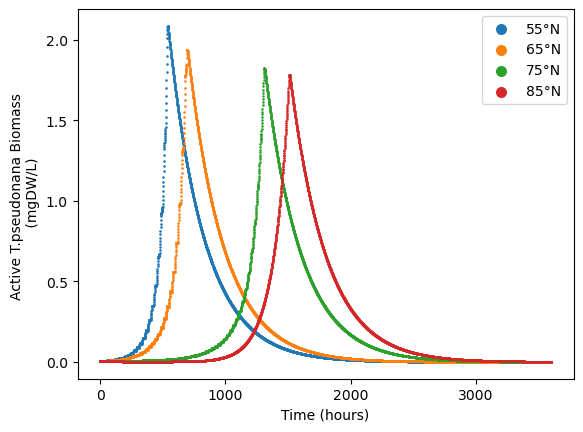

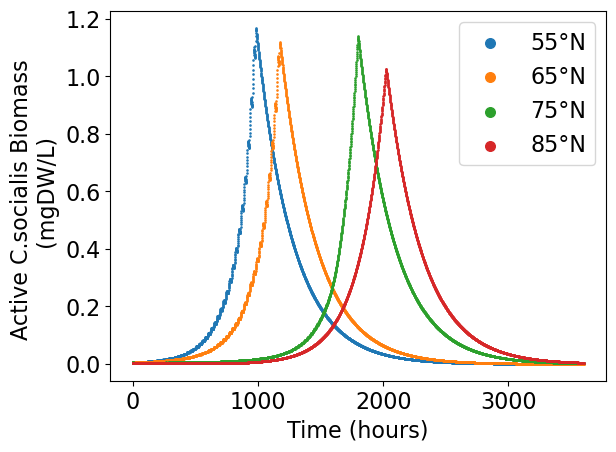

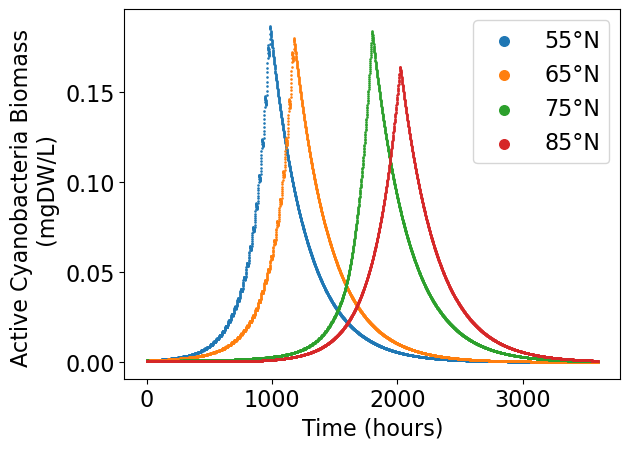

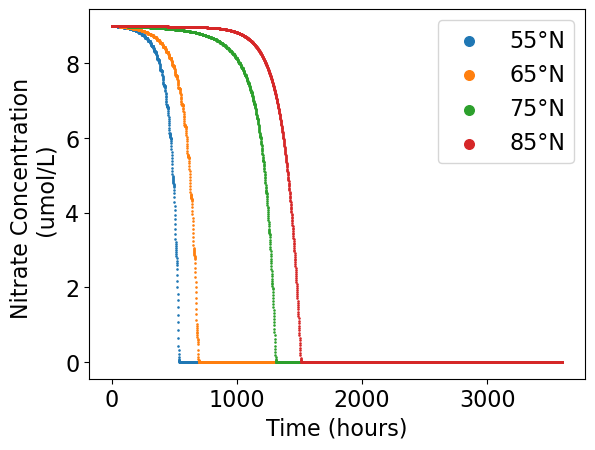

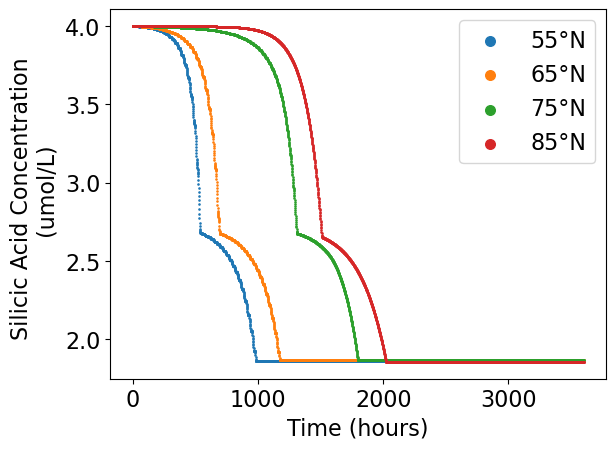

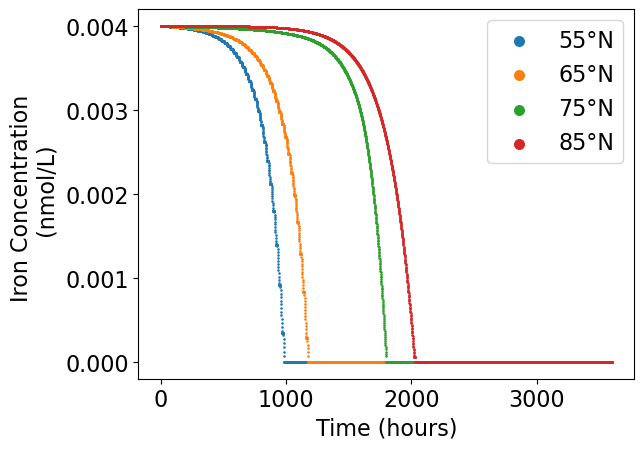

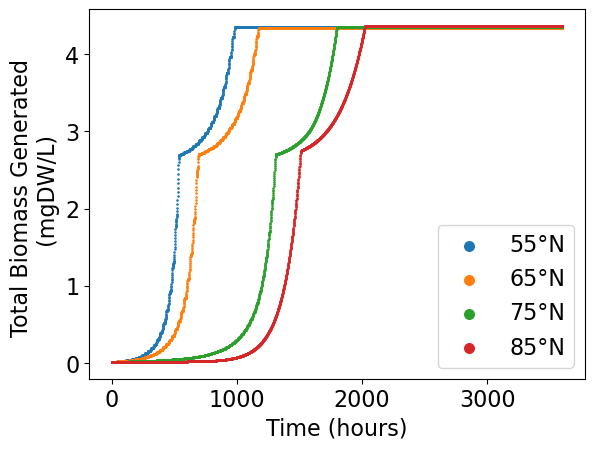

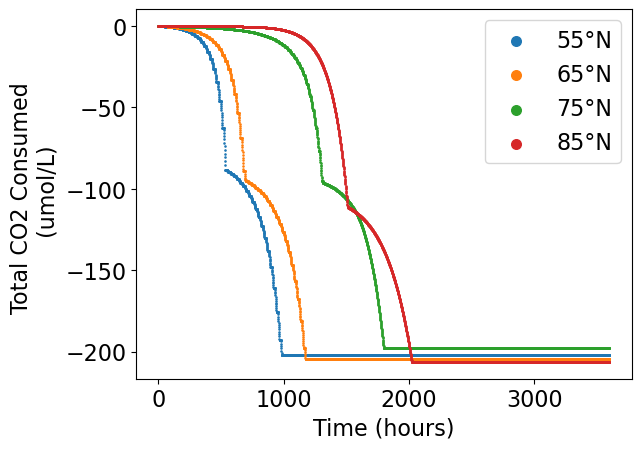

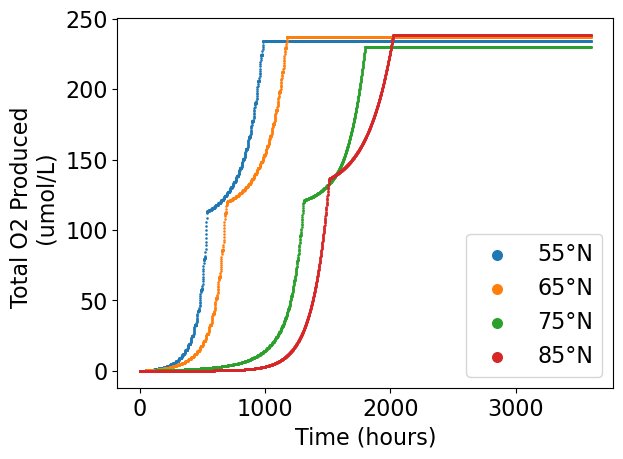

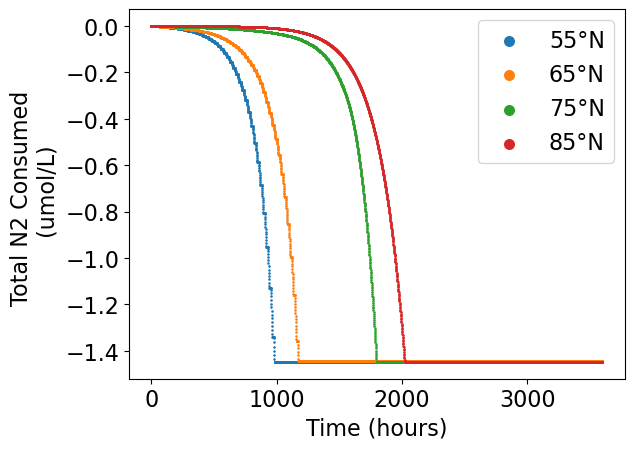

In [5]:
x = arraydict['arraytime']
lats = [55, 65, 75, 85]
variables = ['arrayTPbio','arrayCSbio','arrayCybio','arrayNO3','arraySiO4H4','arrayFe','arraytotalBM','arraytotalCO2','arraytotalO2','arraytotalN2']
labels = ["Active T.pseudonana Biomass \n (mgDW/L)", "Active C.socialis Biomass \n (mgDW/L)", "Active Cyanobacteria Biomass \n (mgDW/L)", "Nitrate Concentration \n (umol/L)",
           "Silicic Acid Concentration \n (umol/L)", "Iron Concentration \n (nmol/L)", "Total Biomass Generated \n (mgDW/L)", "Total CO2 Consumed \n (umol/L)",
           "Total O2 Produced \n (umol/L)", "Total N2 Consumed \n (umol/L)"]
filenames = ["TPBio","CSBio","CyanoBio","Nitrate","Silicic","Iron","TotalBio","TotalCO2","TotalO2","TotalN2"]

for idx, name in enumerate(filenames):
    plt.figure()
            
    for idy, lat in enumerate(lats):
        plt.scatter(x[idy,:],arraydict[variables[idx]][idy,:],s=0.75)

    plt.xlabel("Time (hours)")
    plt.ylabel(labels[idx]) 
    plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N",],markerscale=8)

    plt.rc('font', size=16)          # controls default text sizes
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
    plt.rc('legend', fontsize=16)    # legend fontsize
    plt.rc('figure', titlesize=12)  # fontsize of the figure title
    plt.savefig(("March-AugustNewBigNoLegend " + name + ".pdf"),dpi=1200,format='pdf')

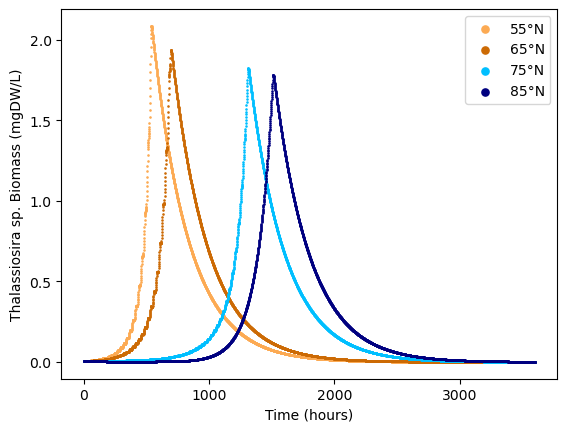

In [4]:
x = arraydict['arraytime']
lats = [55, 65, 75, 85]
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arrayTPbio'][idy,:],s=0.75,c=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel("Thalassiosira sp. Biomass (mgDW/L)")
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=6)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("Figure1.pdf"),dpi=1200,format='pdf')

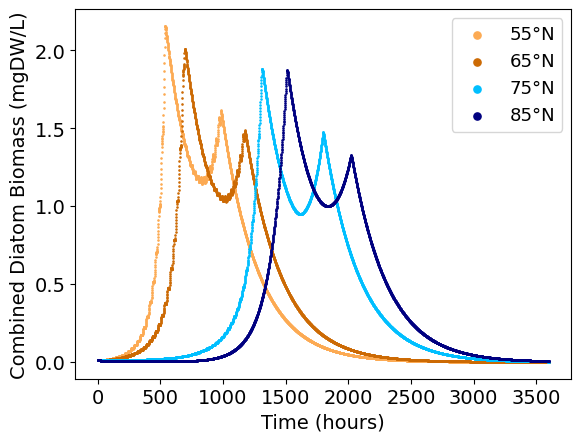

In [15]:
x = arraydict['arraytime']
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],(arraydict['arrayTPbio'][idy,:]+arraydict['arrayCSbio'][idy,:]),s=0.75,c=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel("Combined Diatom Biomass (mgDW/L)")
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=6)

plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("SymFigure5.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

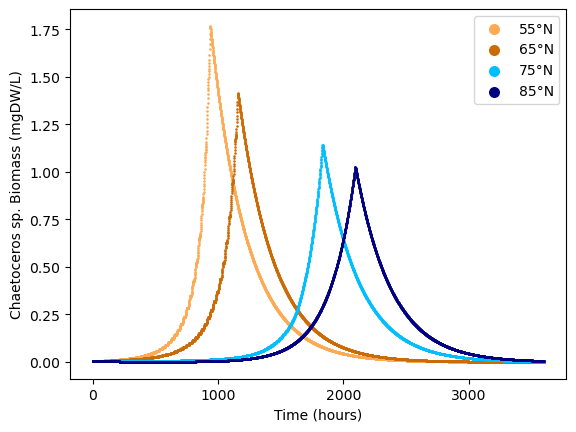

In [6]:
x = arraydict['arraytime']
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arrayCSbio'][idy,:],s=0.75,c=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel("Chaetoceros sp. Biomass (mgDW/L)")
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=8)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("SymFigure4.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

In [ ]:
x = arraydict['arraytime']
colors = ['#fcaa53','#cc6a04','deepskyblue','navy']
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arrayNO3'][idy,:],s=0.75,c=colors[idy])

plt.xlabel("Time (hours)")
plt.ylabel("Chaetoceros sp. Biomass (mgDW/L)")
plt.legend(["55"+chr(176)+"N","65"+chr(176)+"N","75"+chr(176)+"N","85"+chr(176)+"N"],markerscale=8)

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("SymFigure4.pdf"),dpi=1200,format='pdf',bbox_inches='tight')

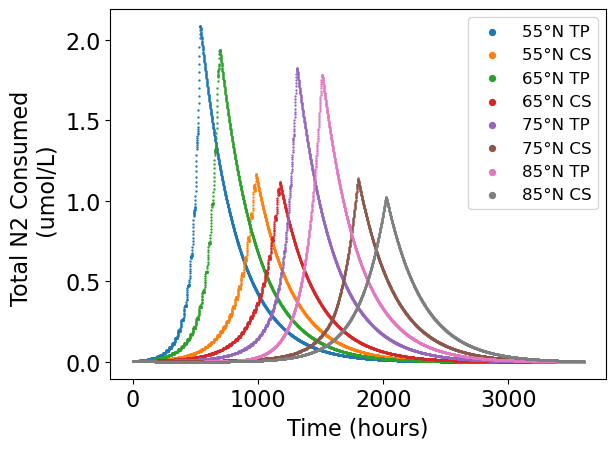

In [22]:
for idy, lat in enumerate(lats):
    plt.scatter(x[idy,:],arraydict['arrayTPbio'][idy,:],s=0.5)
    plt.scatter(x[idy,:],arraydict['arrayCSbio'][idy,:],s=0.5)

plt.xlabel("Time (hours)")
plt.ylabel(labels[idx]) 
plt.legend(["55"+chr(176)+"N TP","55"+chr(176)+"N CS","65"+chr(176)+"N TP","65"+chr(176)+"N CS",
            "75"+chr(176)+"N TP","75"+chr(176)+"N CS","85"+chr(176)+"N TP","85"+chr(176)+"N CS"],markerscale=6)

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title
plt.savefig(("SuccessionSeparateBio.pdf"),dpi=1200,format='pdf')

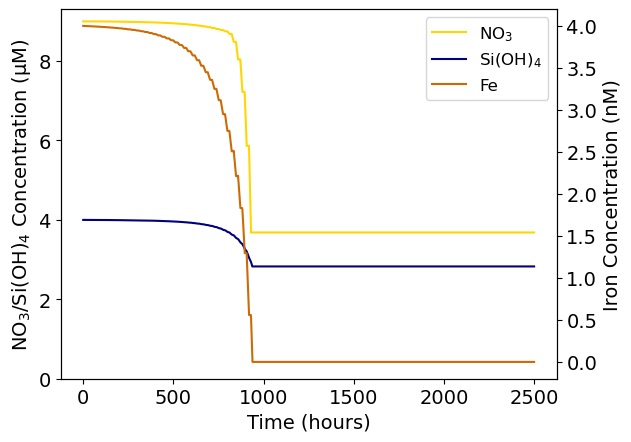

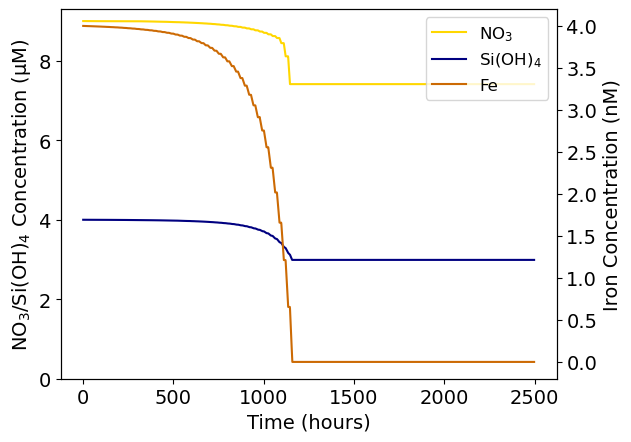

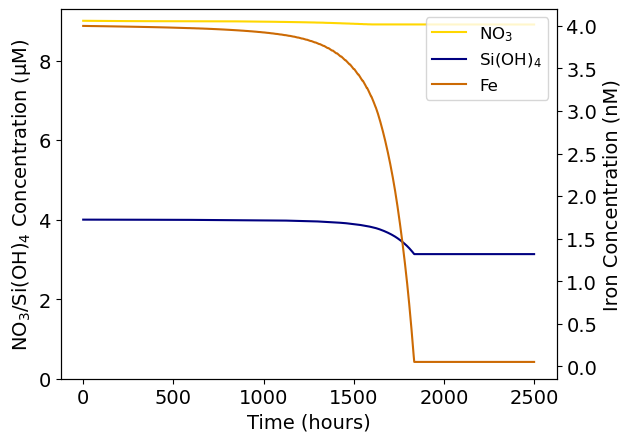

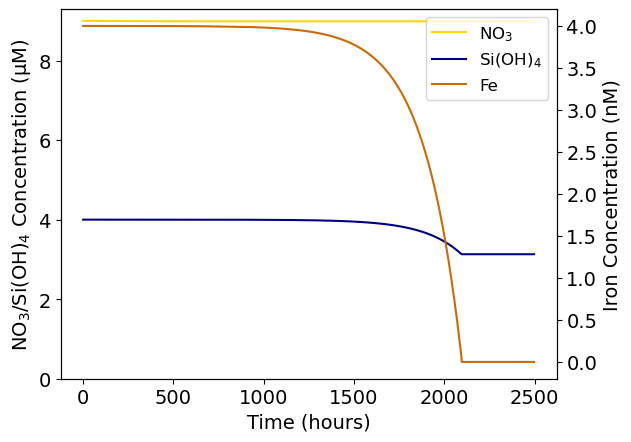

In [9]:
colors = ['blue','green','red','purple']
latstr = ['55', '65', '75', '85']
FigureMarker = ['a','b','c','d']
for idy, lat in enumerate(lats):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel(u"$\mathregular{NO_3}$/$\mathregular{Si(OH)_4}$ Concentration (\u03bcM)")
    ax1.plot(x[idy,:2500],arraydict['arrayNO3'][idy,:2500],color='gold',label="Nitrate")    
    ax1.plot(x[idy,:2500],arraydict['arraySiO4H4'][idy,:2500],color='navy',label="Silicon")
    ax1.set_ylim(bottom=0)
    # ax1.legend(loc="upper right")
    # plt.scatter(x[idy,:],arraydict['arrayNO3'][idy,:],color=colors[idy],label=latstr[idy]+chr(176)+"N",s=0.75)    
    # plt.scatter(x[idy,:],arraydict['arraySiO4H4'][idy,:],color=colors[idy],s=0.75)
    # plt.scatter(x[idy,:],arraydict['arrayFe'][idy,:],color=colors[idy],s=0.75)
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('Iron Concentration (nM)')
    ax2.plot(x[idy,:2500],arraydict['arrayFe'][idy,:2500]*1000,color='#cc6a04',label="Iron")
    # ax2.legend(loc="upper right",bbox_to_anchor=(1,0.86))
    
    fig.legend(["$\mathregular{NO_3}$","$\mathregular{Si(OH)_4}$","Fe"],markerscale=10, bbox_to_anchor=(0.9,0.88))
    
    # plt.xlabel("Time (hours)")
    # plt.ylabel("NO3/SiO4H4 Concentration \n (umol)") 
    # plt.legend(["Nitrate","Silicon","Iron"],markerscale=8)

    plt.rc('font', size=16)          # controls default text sizes
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('legend', fontsize=12)    # legend fontsize
    plt.rc('figure', titlesize=12)  # fontsize of the figure title
    # fig.tight_layout()
    plt.savefig(("SymFigure6"+FigureMarker[idy]+".pdf"),dpi=1200,format='pdf',bbox_inches='tight')